In [5]:
# from visualization import *
import scienceplots
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def plot_loss_model(file_list,model_type,loss_type,single_model_nuber):
    # legend_list = [os.path.splitext(os.path.split(file)[1])[0] for file in file_list]

    if not file_list:
        print("the file list is empty")
    else:
#         legend_list = [os.path.split(file)[1].split('./')[0] for file in file_list]
        legend_list = [os.path.split(os.path.split(file)[0])[1] for file in file_list]
        x_lim_list = []
        
        plt.style.use(['science', 'no-latex'])

        plt.figure(dpi=500)
        for i in range(len(file_list)):
            train_history = train_history_pklfile(file_list[i])
            loss = model_loss_history(train_history,model_type,loss_type,single_model_nuber = single_model_nuber)
            plt.plot(loss,label=legend_list[i])    
            x_lim_list.append(len(loss))

        plt.xlabel("batch")
        plt.xlim((0, min(x_lim_list)))
        # plt.ylim((0, 15))
        plt.ylabel(loss_type)
        # plt.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(loc='upper right')
        if single_model_nuber == False:
            plt.title(" model active learning training history")
        else:
            # plt.title(model_type + " model "+str(single_model_nuber)+ " active learning training history")
            plt.title(" model active learning training history")
        
        plt.savefig(model_type + "_" + loss_type + ".png", dpi=500, bbox_inches='tight')
        plt.show()


def train_history_pklfile(pklfile):
    return pd.read_pickle(pklfile)

def model_loss_history(train_history,model_type,loss_type,single_model_nuber = False):
    '''
    model type: 'single', 'ensemble'
    single_model_nuber: the each single model member number
    loss_type: 'train_binary_losses', 'train_semantic_losses', 'val_binary_losses', 'val_semantic_losses'
    '''
    loss = []
    for i in range(len(train_history.keys())):
        if model_type == 'single':
            loss.append(train_history[i][single_model_nuber][model_type][loss_type][-1])
        elif model_type == 'ensemble':
            # ensemble_all = list(train_history[0].keys())[-1]
            # loss.append(train_history[i][ensemble_all][model_type][loss_type][0])
            loss.append(train_history[i][single_model_nuber][model_type][loss_type][-1])
    return loss

  

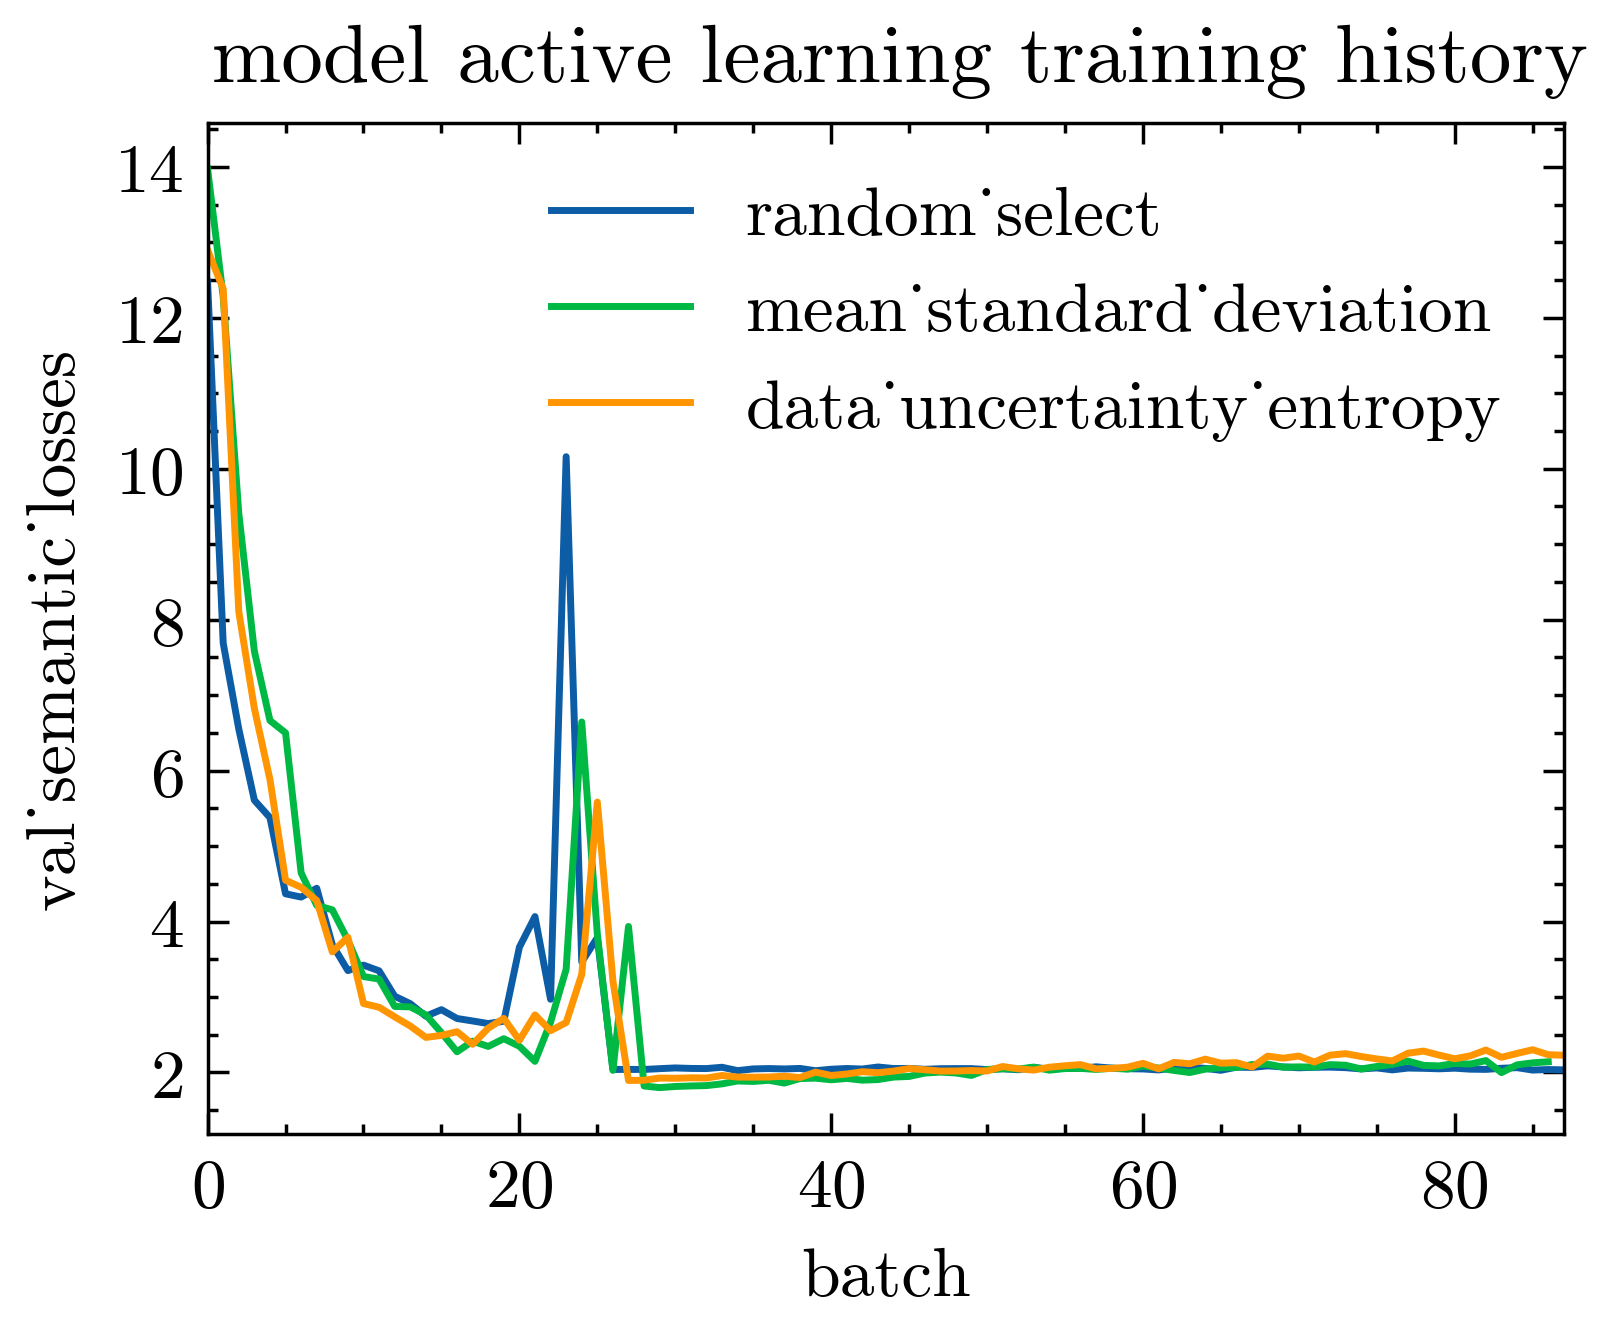

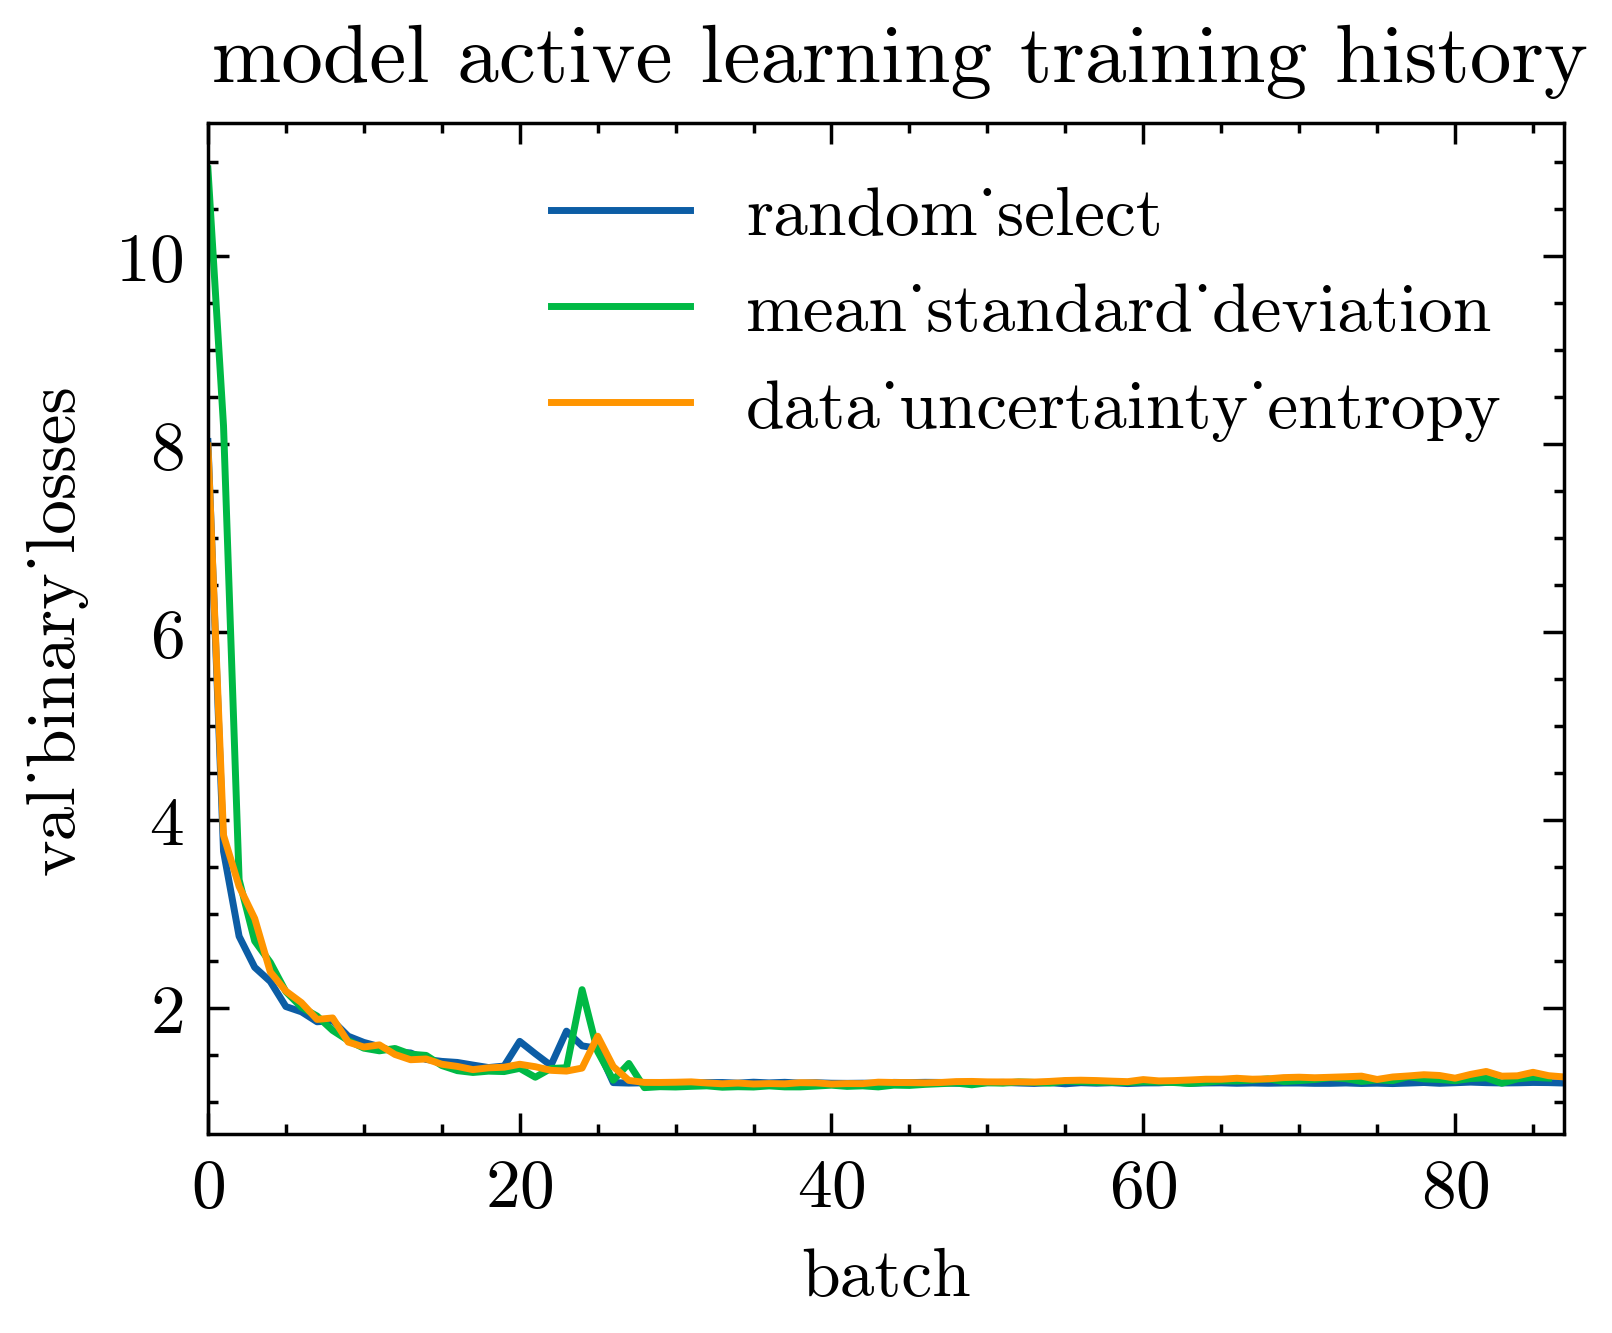

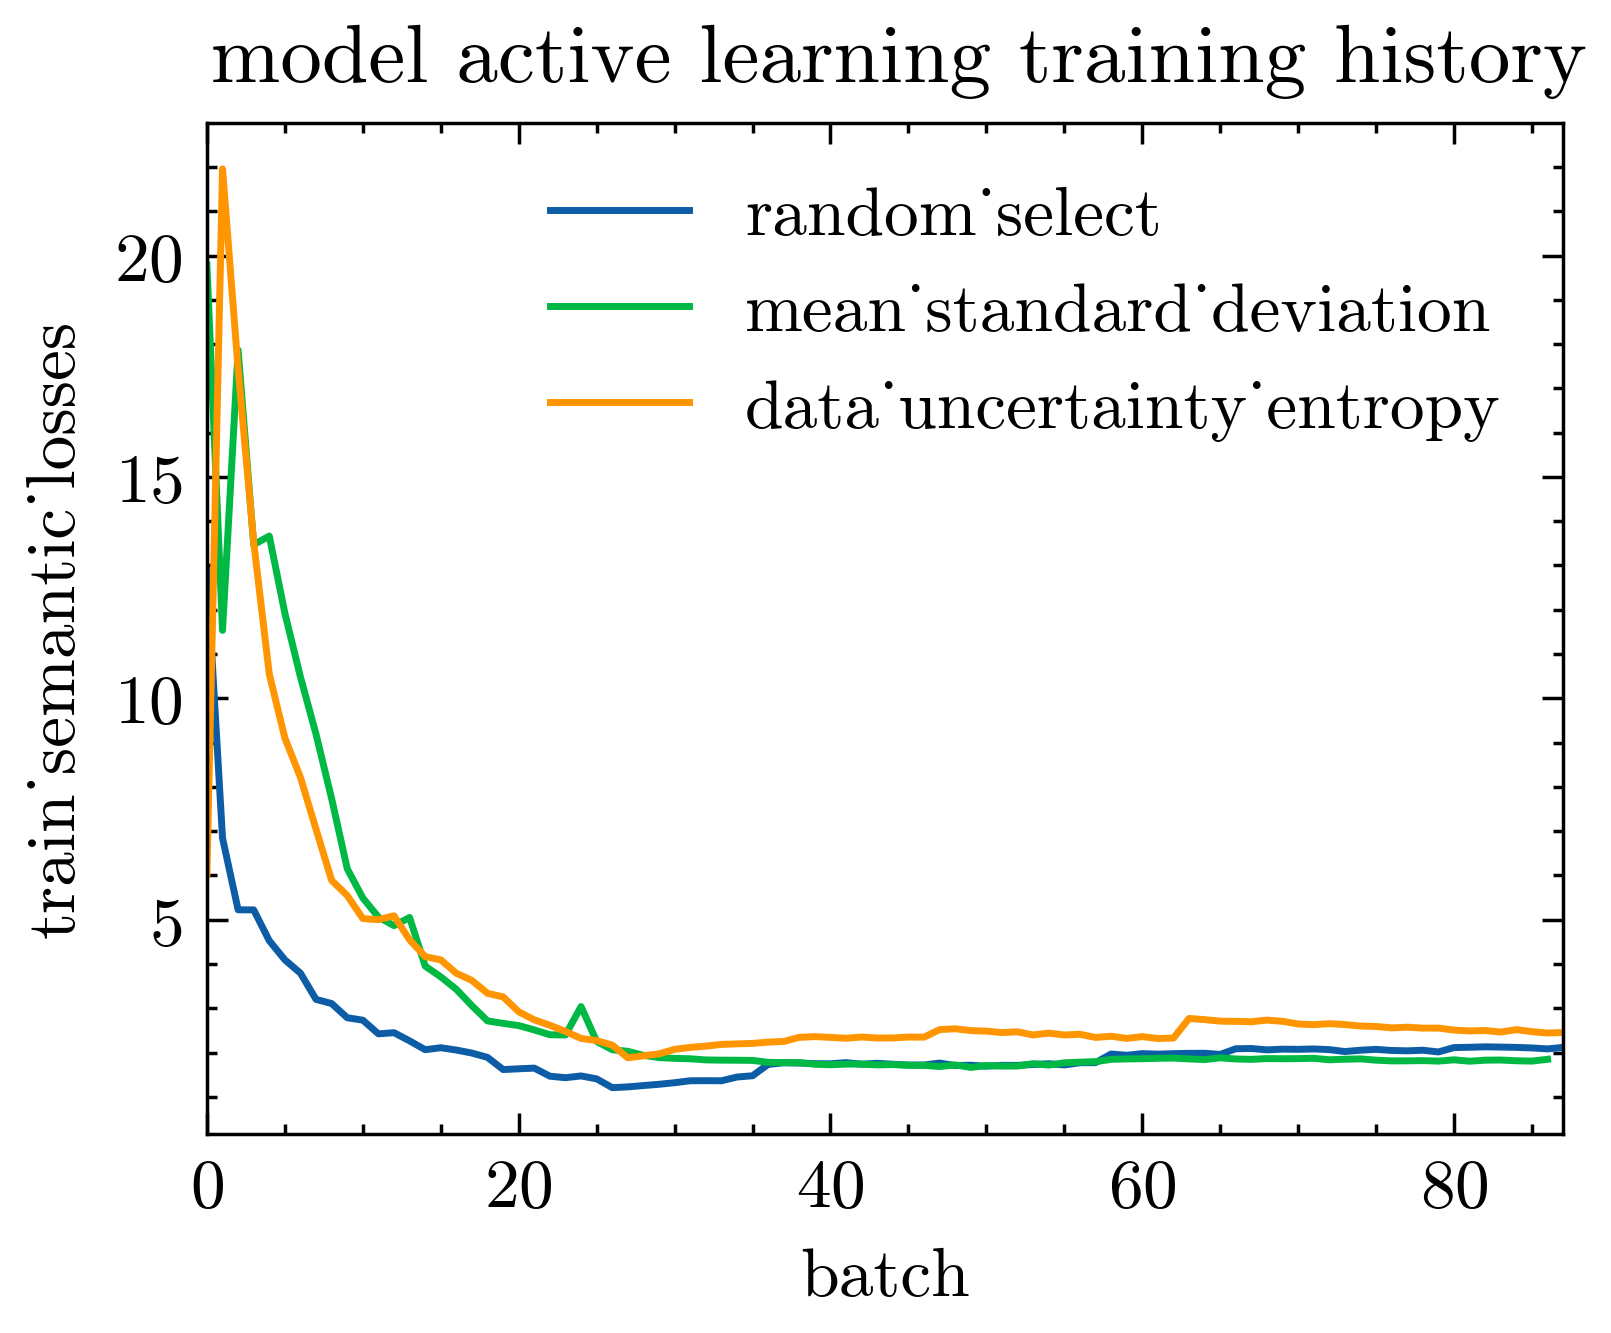

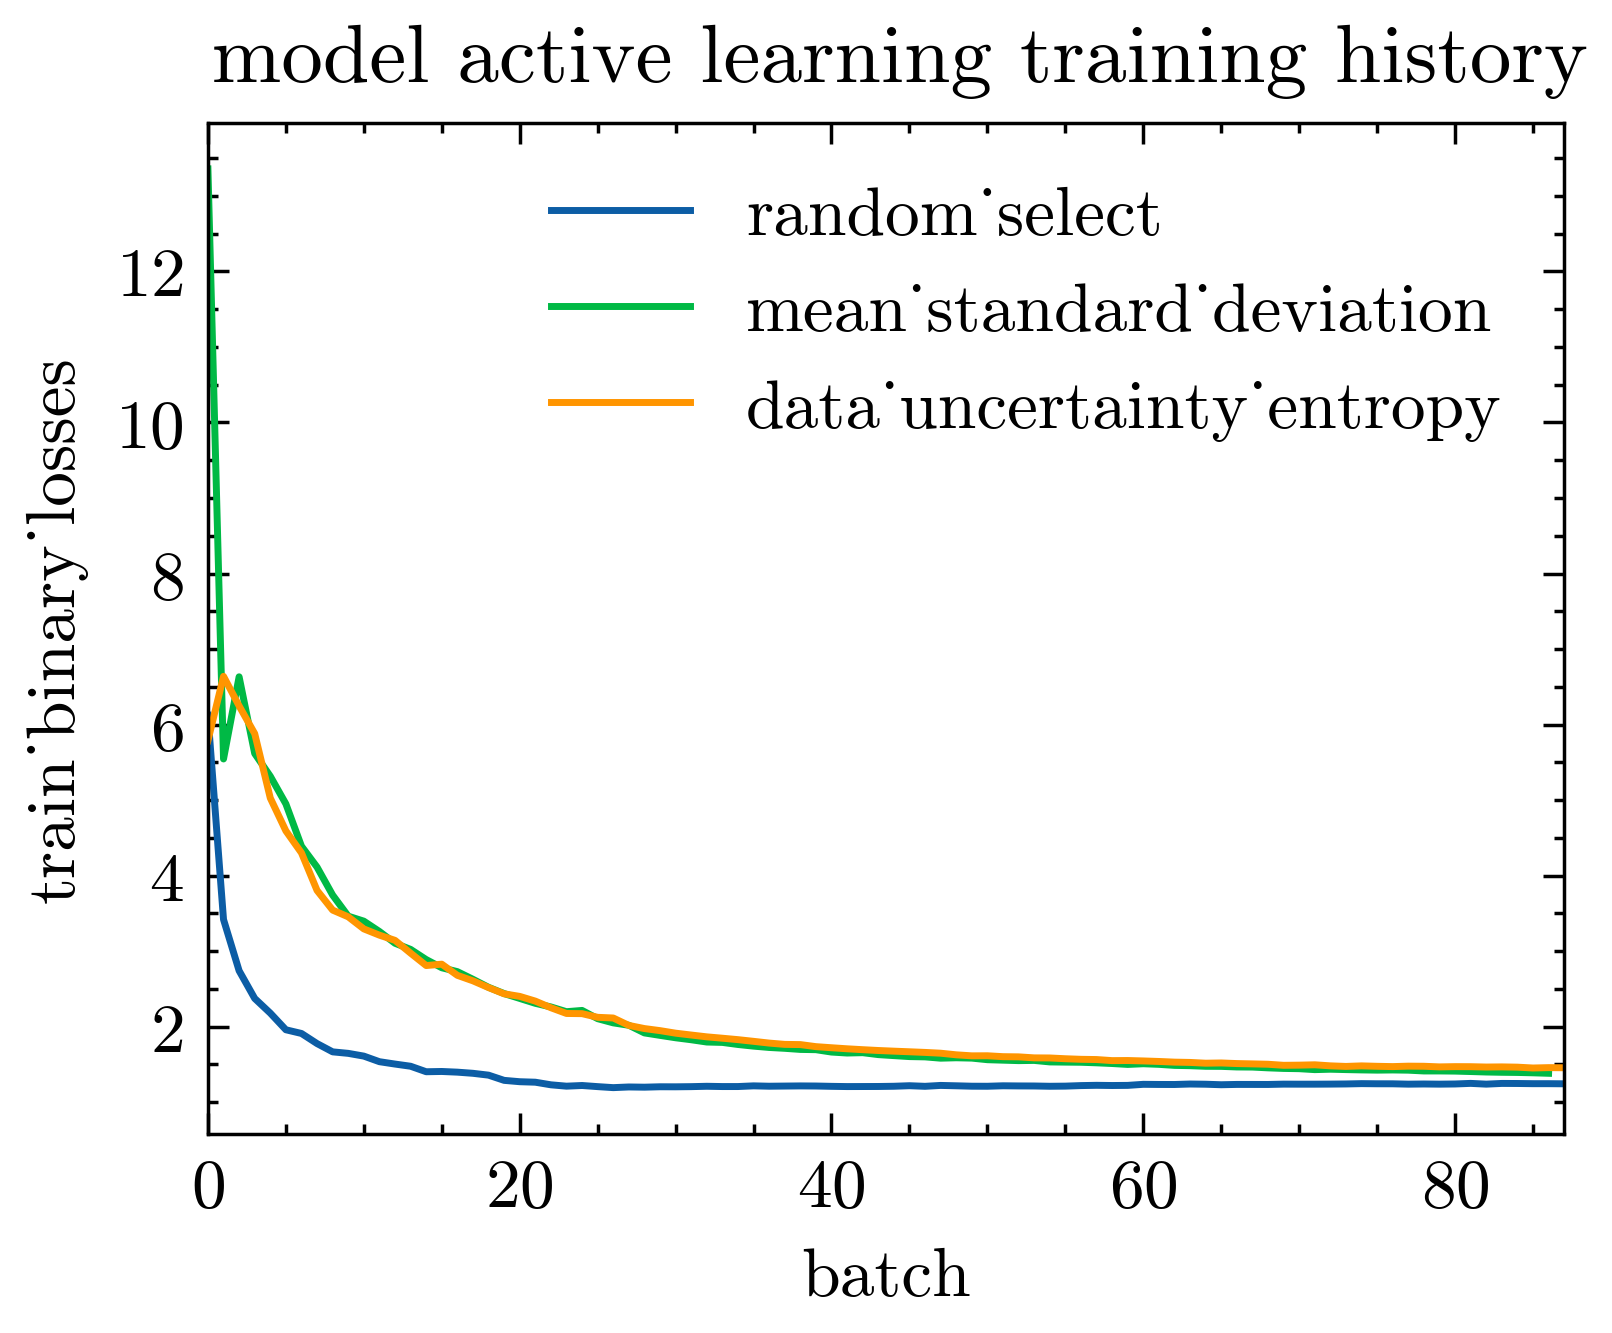

In [7]:
file_list = [                      
            'Training/random_select/entropy_history.pkl',
            'Training/mean_standard_deviation/entropy_history.pkl',
            'Training/data_uncertainty_entropy/entropy_history.pkl' 
            ]

plot_loss_model(file_list,'ensemble','val_semantic_losses', 4)
plot_loss_model(file_list,'ensemble','val_binary_losses', 4)
plot_loss_model(file_list,'ensemble','train_semantic_losses', 4)
plot_loss_model(file_list,'ensemble','train_binary_losses', 4)

In [6]:
data_generator_val = DataGenerator(paths_to_samples_dict['paths_val'],
                                           class_name_to_class_idx_semantic,class_name_to_class_idx_object,
                                loss_weights_tensor_object,loss_weights_tensor_semantic,cuda=cuda,batch_size = 1,
                     augmentation_probability=0,steps_per_epoch=int(len(paths_to_samples_dict['paths_val'])))

Number of image tiles:  2693
Number of semantic classes (excluding unknown class):  15
Image size:  128


To load the model and compute the accuracy from the data_generator_val

In [8]:
def acc_list(save_folder,epoch,data_generator,pixel_acc_history,obj_acc_history ):
    '''
    compute the accuracy with the model at epoch 
    '''
    load_dir = save_folder + str(epoch + 1) + '/' + os.listdir(save_folder + str(epoch + 1))[0]
    model,optimizers_old = load_model(load_dir,device='cuda')

    confusion_matrix_pixel_val,confusion_matrix_object_val,n_pixels_tot_val,n_pixels_correct_val,labels_in_val,probabilities_in_val=get_performance_statistics(
        data_generator_val,model,n_batches=int(len(paths_to_samples_dict['paths_val'])/20))
    
    pixel_acc_history.append(n_pixels_correct_val/n_pixels_tot_val)

    obj_acc = []
    
    '''
    here there are 16 classes, it may change, if you don't want the accuracy per object in each class, remove the following lines to accelerate
    '''
    for i in range(16):
        obj_acc.append(get_top_k_accuracy(probabilities_in_val,labels_in_val,K=i))
    obj_acc_history.append(obj_acc)
    
    return pixel_acc_history,obj_acc_history 



def acc_list_folder(save_folder):
    '''
    compute the accuracy history training with the epoch growing
    '''
    obj_acc_history = []
    pixel_acc_history = []
    epoch_tot = new_batch_root(save_folder)
    for epoch in range(epoch_tot):

        data_generator = DataGenerator(
            
            paths_to_samples_dict['paths_val'],
                                           class_name_to_class_idx_semantic,class_name_to_class_idx_object,
                                loss_weights_tensor_object,loss_weights_tensor_semantic,cuda=cuda,batch_size = 20,
                     augmentation_probability=0,steps_per_epoch=int(len(paths_to_samples_dict['paths_val'])/20))

        pixel_acc_history,obj_acc_history = acc_list(save_folder,epoch,data_generator,pixel_acc_history,obj_acc_history)
    return pixel_acc_history,obj_acc_history

Save the accuracy as pkl file 

In [7]:
save_folder_list = [                      
            '/Training/random_select/',
            '/Training/mean_standard_deviation/',
            '/Training/data_uncertainty_entropy/' 
            ]

for save folder in save_folder_list:
    acc_random,obj = acc_list_folder(save_folder)
    save_dic_pkl(save_folder+'acc.pkl',acc_random)

SyntaxError: invalid syntax (3278608697.py, line 7)

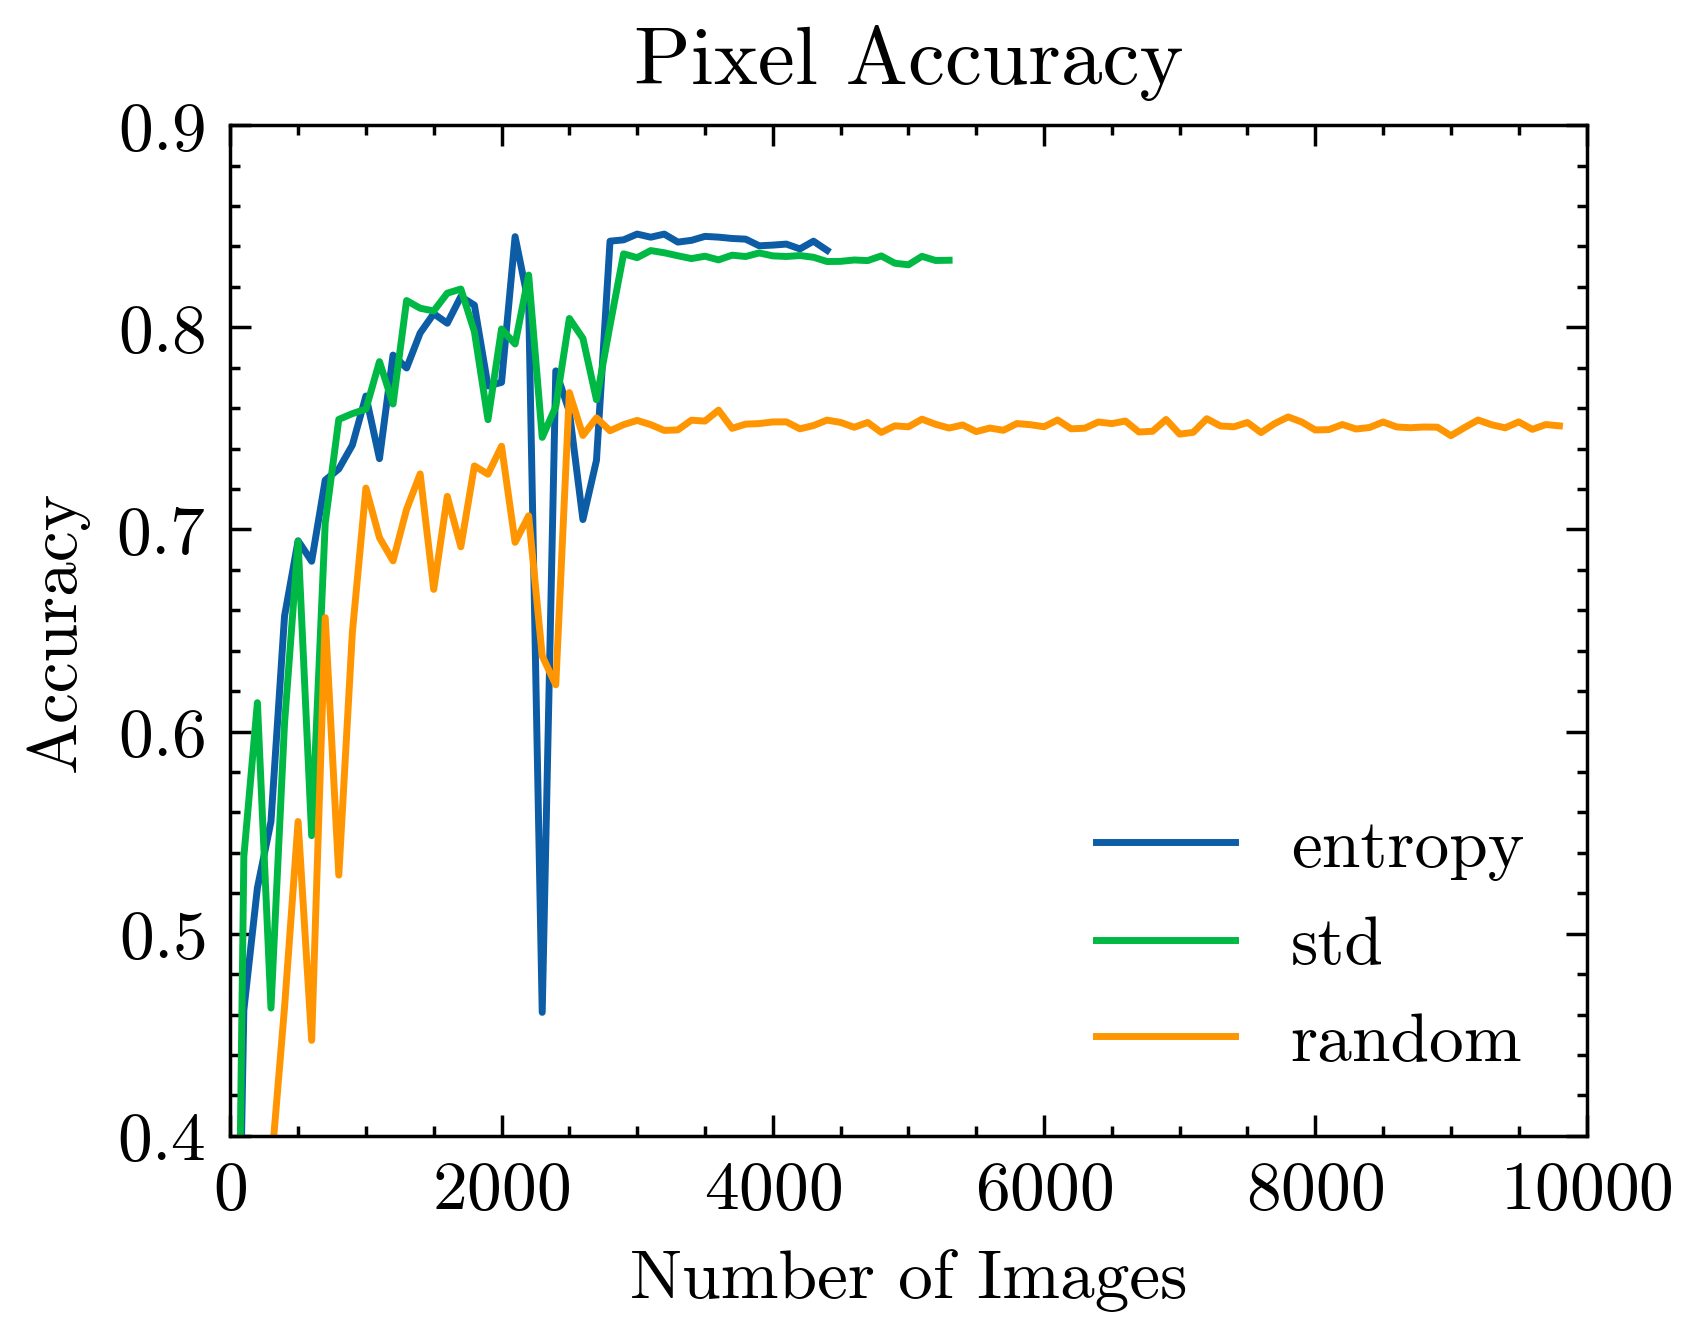

In [3]:
import scienceplots
import matplotlib.pyplot as plt

def pkl_file_path(pathname):

    if os.path.exists(pathname):
        read_file = pd.read_pickle(pathname)
    else:
        read_file = {}
    return read_file


a = pkl_file_path('Training/data_uncertainty_entropy/acc.pkl')
b =  pkl_file_path('Training/mean_standard_deviation/acc.pkl')
c =  pkl_file_path('Training/random_select/acc.pkl')



plt.style.use(['science', 'no-latex'])

plt.figure(dpi=500)
x = np.array(list(range(len(a))))*100
plt.plot(x,a)
x = np.array(list(range(len(b))))*100
plt.plot(x,b)
x = np.array(list(range(len(c))))*100
plt.plot(x,c)


plt.ylim(0.4,0.9)
plt.xlim(0,10000)
plt.legend(['entropy','std','random'])
# plt.legend(['std','std_tot'])
plt.xlabel('Number of Images')
plt.ylabel('Accuracy')
plt.title("Pixel Accuracy")
plt.savefig('pixel_acc.png', dpi=500, bbox_inches='tight')
plt.show()



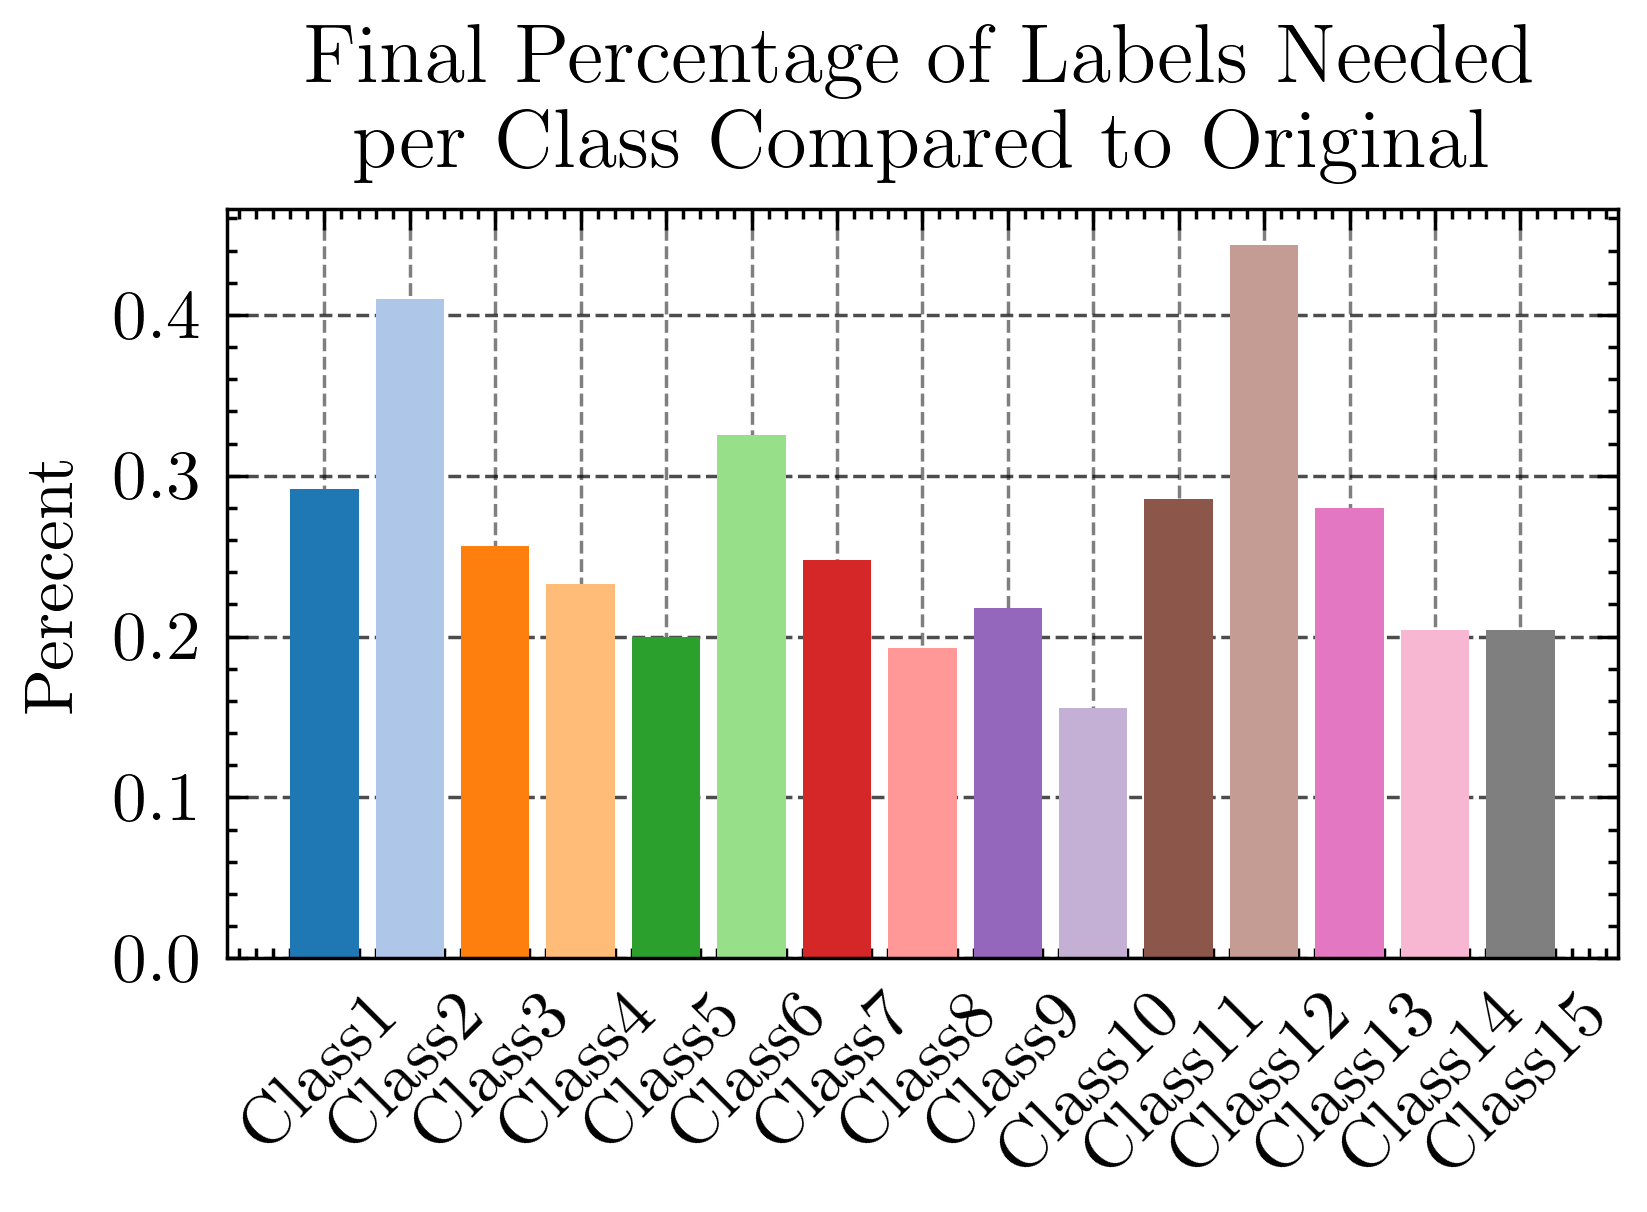

In [10]:

import pandas as pd
import scienceplots
import matplotlib.pyplot as plt

# Data
data = {
    "Class1": 0.292084600014809,
    "Class2": 0.410005309825461,
    "Class3": 0.256268831519835,
    "Class4": 0.232716526511518,
    "Class5": 0.199488718461709,
    "Class6": 0.325533179990298,
    "Class7": 0.247869464941575,
    "Class8": 0.192656981422675,
    "Class9": 0.21760126784148,
    "Class10": 0.15569949607278,
    "Class11": 0.285405659352025,
    "Class12": 0.443624304301727,
    "Class13": 0.280185608421636,
    "Class14": 0.203845900125338,
    "Class15": 0.204339051463169
}


# Convert to DataFrame
df = pd.DataFrame(list(data.items()), columns=["Class", "Value"])

# Assign different colors
colors = plt.cm.tab20.colors[:len(df)]  # pick enough distinct colors


plt.style.use(['science', 'grid'])
plt.figure(dpi=500)
# plt.figure(figsize=(10, 6))
plt.bar(df["Class"], df["Value"], color=colors)
plt.xticks(rotation=45)
plt.ylabel("Perecent")
plt.title("Final Percentage of Labels Needed \n per Class Compared to Original")

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('class_values_histogram.png', dpi=500, bbox_inches='tight')
plt.show()

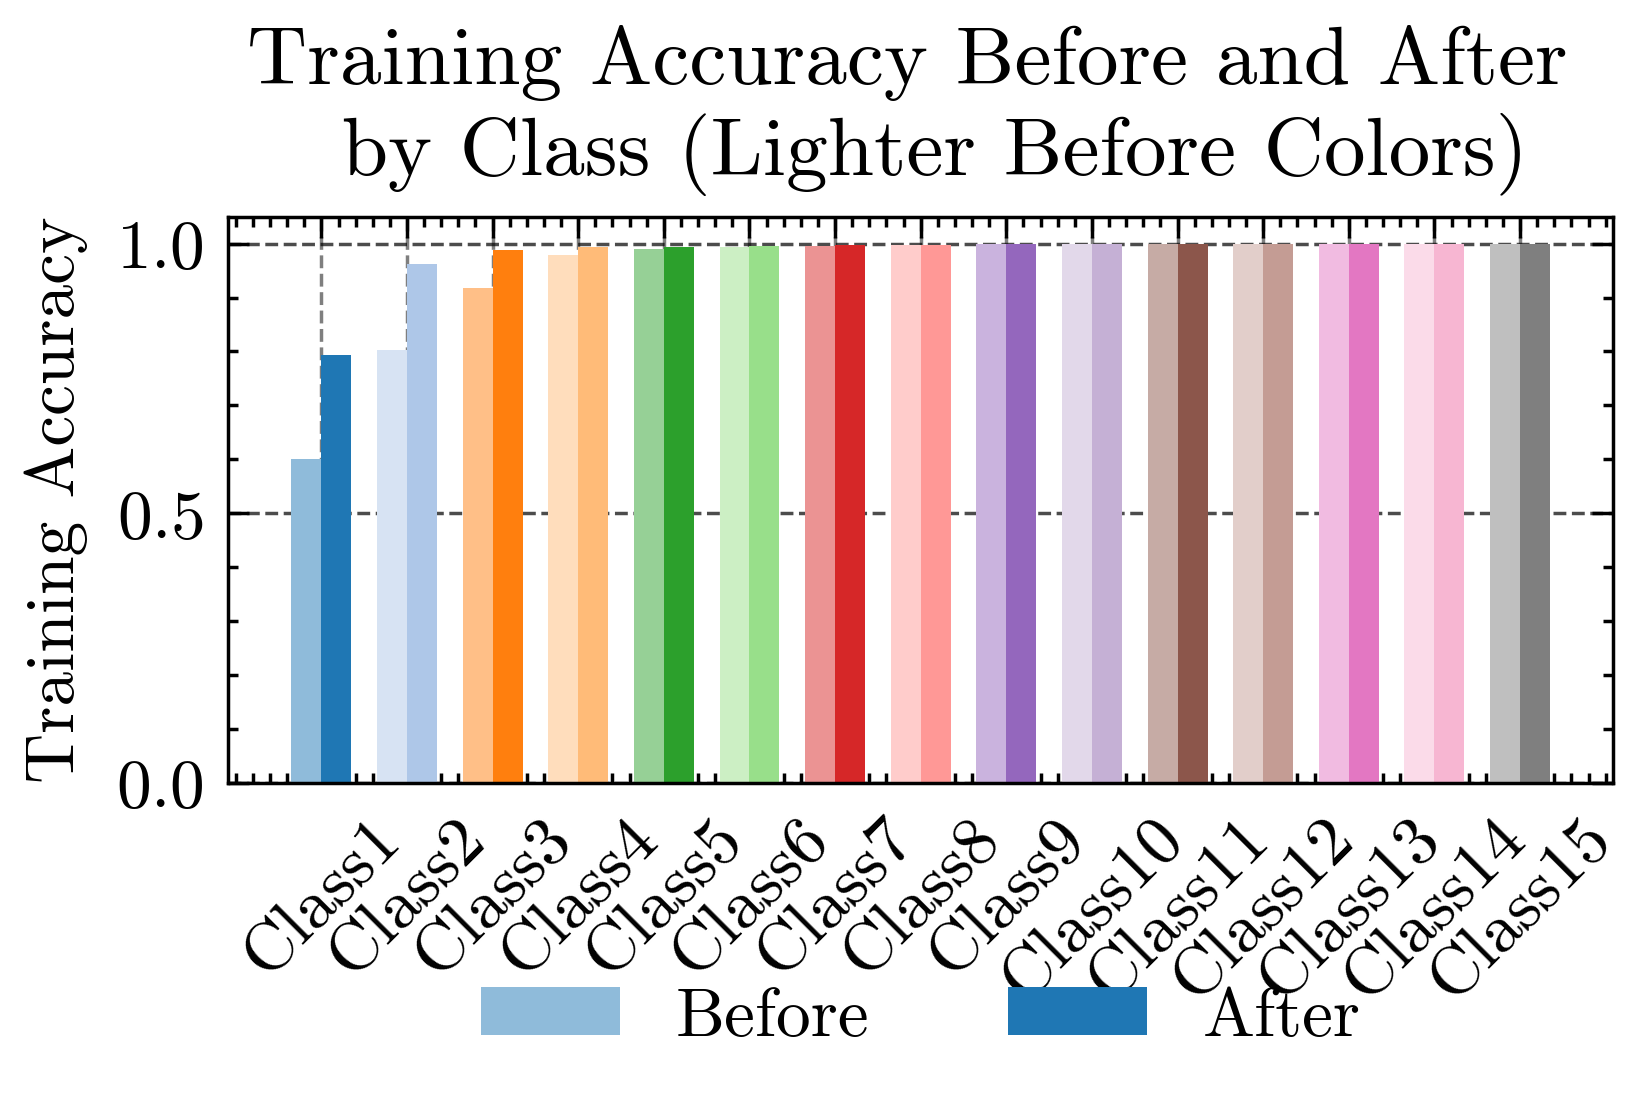

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# Data
data = {
    "Class1": [0.599667929033823, 0.794302557692666],
    "Class2": [0.803555771132213, 0.963211014308901],
    "Class3": [0.91838143387497, 0.98854541723411],
    "Class4": [0.979180269761021, 0.992948155886797],
    "Class5": [0.989888625636625, 0.994795067440255],
    "Class6": [0.994552543700912, 0.996604667649199],
    "Class7": [0.995933063447941, 0.997761319329142],
    "Class8": [0.997724007984628, 0.998097121429771],
    "Class9": [0.999514952521314, 0.9990858720594],
    "Class10": [1, 0.999291084454228],
    "Class11": [1, 0.999291084454228],
    "Class12": [1, 1],
    "Class13": [1, 1],
    "Class14": [1, 1],
    "Class15": [1, 1]
}


# Convert to DataFrame
df = pd.DataFrame(data, index=["Before", "After"]).T

# X positions
x = np.arange(len(df))
width = 0.35

# Base colors
base_colors = plt.cm.tab20.colors[:len(df)]

# Create lighter colors for "Before"
lighter_colors = []
for color in base_colors:
    r, g, b = color[:3]
    lighter = (r + 1) / 2, (g + 1) / 2, (b + 1) / 2  # Blend toward white
    lighter_colors.append(lighter)

# Plot
# fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use(['science', 'no-latex'])

fig, ax = plt.subplots(dpi=500)
bars_before = ax.bar(x - width/2, df["Before"], width, label='Before', color=lighter_colors)
bars_after = ax.bar(x + width/2, df["After"], width, label='After', color=base_colors)

# Labels and formatting
ax.set_ylabel('Training Accuracy')
ax.set_title('Training Accuracy Before and After \n by Class (Lighter Before Colors)')
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
## plot the legen in the bottom outside
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False)
plt.tight_layout()
plt.savefig('training_accuracy_before_after.png', dpi=500, bbox_inches='tight')
plt.show()
